<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/Modeling_and_Prediction_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM BASELINE MODEL

In diesem Skript wird ein erstes Modell erzeugt, um aus den gemssenen Globalstrahlungsdaten den UVI zu berechen.

In [1]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow
!pip install keras

In [3]:
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
# Pfad zur CSV-Datei auf Google-Drive
name_Messwerte = 'Messdaten_CAMS_GHI.csv'
name_Vorhersage = 'Vorhersagedaten_CAMS_VarIdx.csv'
folder_import = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'

In [5]:
# Pfad zum Abspeichern des trainierten Modells in Google-Drive

model_path = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/full_model.keras'
weights_path = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/model_weights.weights.h5'

# Pfad für den Testdatensatz

testdata_path = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/model_testdata.csv'

In [6]:
# Import der Messdaten
df_Messdaten = pd.read_csv(folder_import + name_Messwerte)

In [7]:
# Import der Vorhersagedaten
df_Vorhersage = pd.read_csv(folder_import + name_Vorhersage)

In [8]:
# Konvertiere die Zeitspalten in ein gemeinsames Format und führe einen Merge der Datensätze durch
df_Messdaten['Datetime'] = pd.to_datetime(df_Messdaten['Datetime'])
df_Vorhersage['Datetime'] = pd.to_datetime(df_Vorhersage['Datetime'])

In [9]:
# Spalten in den Messdaten
df_Messdaten.columns

Index(['Datetime', 'Observation_period', 'Clear_sky_GHI', 'Clear_sky_BHI',
       'GHI', 'BHI', 'UVI', 'UVA', 'UVB', 'erythem', 'Datum', 'Uhrzeit',
       'Messzeitpunkt', 'ghi', 'Dif', 'Glo_SPLite', 'Dir', 'Temp',
       'DiffGreater2', 'SZA', 'time_sin', 'time_cos', 'date_sin', 'date_cos',
       'Date', 'Hour'],
      dtype='object')

In [10]:
# Relevante Spalten
# indipendent_variablen = ['ghi', 'SZA', 'time_sin', 'time_cos', 'date_sin', 'date_cos']
# indipendent_variablen = ['ghi']
indipendent_variablen = ['SZA']
dependent_variablen = ['UVI']

columns = indipendent_variablen + dependent_variablen

In [11]:
#Applying a scaler for regression
MMS = MinMaxScaler()
df_Messdaten[columns] = MMS.fit_transform(df_Messdaten[columns])

In [12]:
# Bestimme die Index-Grenzen für Train, Validation und Test
total_length = len(df_Messdaten)
train_size = round(total_length * 0.80)
val_size   = round(total_length * 0.10)
# Hier bleiben dann (total_length - train_size - val_size) für den Test übrig

# Aufteilen des Datensatzes
train_data = df_Messdaten[columns][:train_size]
val_data   = df_Messdaten[columns][train_size:train_size + val_size]
test_data  = df_Messdaten[columns][train_size + val_size:]

print(train_data, test_data)

            SZA       UVI
0      0.394655  0.281919
1      0.390193  0.281919
2      0.385734  0.288240
3      0.381277  0.290191
4      0.376825  0.297739
...         ...       ...
77381  0.574718  0.093193
77382  0.579150  0.078514
77383  0.583587  0.070488
77384  0.588028  0.067234
77385  0.592473  0.062044

[77386 rows x 2 columns]             SZA       UVI
87059  0.046706  0.056318
87060  0.047546  0.044354
87061  0.048457  0.038095
87062  0.049436  0.033411
87063  0.050485  0.033445
...         ...       ...
96727  0.718702  0.035933
96728  0.714245  0.036573
96729  0.709785  0.036784
96730  0.705323  0.037088
96731  0.700858  0.036570

[9673 rows x 2 columns]


In [13]:
  def create_sequence(dataset, sequence_len):
    sequences = []
    labels = []
    start_idx = 0
    for stop_idx in range(sequence_len, len(dataset)):
        # Nimm alle Features als Input-Sequenz
        sequences.append(dataset.iloc[start_idx:stop_idx].values)
        # Nimm nur die letzte Spalte (z. B. -1, wenn es "UVI" ist)
        labels.append(dataset.iloc[stop_idx, -1])
        start_idx += 1

    return np.array(sequences), np.array(labels)

In [26]:
# Erstellen des Trainigs- und Validierungsdatensatzes
X_train, y_train = create_sequence(train_data,16)
X_val, y_val = create_sequence(val_data,16)
X_test, y_test = create_sequence(test_data,16)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(77370, 16, 2) (77370,) (9657, 16, 2) (9657,)


In [15]:
#Creating LSTM for regression

model = Sequential()
model.add(LSTM(units = 64, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units = 32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
history = model.fit(X_train, y_train, epochs = 4, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/4
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 67s 26ms/step - loss: 0.0027 - mean_absolute_error: 0.0265 - val_loss: 0.0015 - val_mean_absolute_error: 0.0199
Epoch 2/4
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 50s 21ms/step - loss: 8.7123e-04 - mean_absolute_error: 0.0144 - val_loss: 0.0015 - val_mean_absolute_error: 0.0225
Epoch 3/4
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 80s 20ms/step - loss: 7.7322e-04 - mean_absolute_error: 0.0128 - val_loss: 0.0014 - val_mean_absolute_error: 0.0189
Epoch 4/4
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 84s 21ms/step - loss: 7.0769e-04 - mean_absolute_error: 0.0120 - val_loss: 0.0012 - val_mean_absolute_error: 0.0167


In [27]:
# Berechnen des vorhergesagten UVI
y_pred = model.predict(X_test).flatten()

302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [28]:
# Püfen, ob die Vorhersage den selben Shape hat wie
print(y_pred.shape, y_test.shape)

(9657,) (9657,)


In [29]:
# Abspeichern des trainierten Modells und der Gewichte

model.save(model_path)
model.save_weights(weights_path)

# Abspeichern des Testdatensatzes für eine spätere Auswertung

test_data.to_csv(testdata_path,index=False)

## Berechnung der Qualitätsparameter:

In [30]:
def compare_model_output(model, X_test, y_test, plot_indices=None):
    """
    Vergleicht den Output des Modells mit den wahren Testdaten.

    Parameter:
    -----------
    model : keras.Model
        Das trainierte Modell.
    X_test : np.array
        Die Eingabedaten (Sequenzen) für den Test.
    y_test : np.array
        Die tatsächlichen Zielwerte (Labels) für den Test.
    plot_indices : tuple or list (optional)
        Falls angegeben, z.B. (start, end), wird nur dieser Abschnitt für einen Detailplot verwendet.
    """

    # Vorhersage berechnen
    y_pred = model.predict(X_test)
    # Arrays abflachen für leichtere Handhabung
    y_pred = y_pred.flatten()
    y_test = y_test.flatten()

    # Metriken berechnen
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Ergebnis ausgeben
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    # Gesamten Vergleich plotten
    plt.figure(figsize=(12, 4))
    plt.plot(y_pred, label='Vorhersage', alpha=0.7)
    plt.plot(y_test, label='Tatsächlicher Wert', alpha=0.7)
    plt.title('Vergleich Vorhersage vs. Tatsächlicher Wert')
    plt.legend()
    plt.show()

    # Optionaler Detailplot für einen Index-Bereich
    if plot_indices is not None:
        start, end = plot_indices
        plt.figure(figsize=(12, 4))
        plt.plot(np.arange(start, end), y_pred[start:end], label='UVI Vorhersage', alpha=0.7)
        plt.plot(np.arange(start, end), y_test[start:end], label='UVI Messung', alpha=0.7)
        plt.title(f'Detailplot (Index {start} - {end})')
        plt.legend()
        plt.show()

302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Mean Squared Error (MSE): 0.0017
Mean Absolute Error (MAE): 0.0197


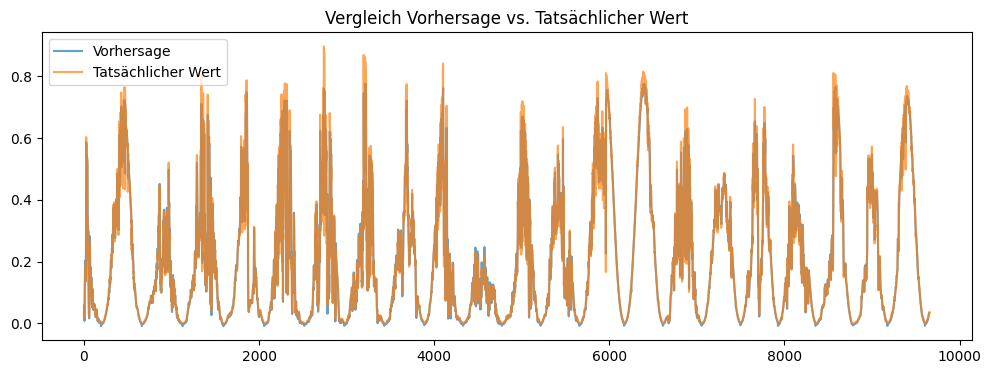

In [31]:
compare_model_output(model, X_test, y_test, plot_indices=None)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Mean Squared Error (MSE): 0.0004
Mean Absolute Error (MAE): 0.0106


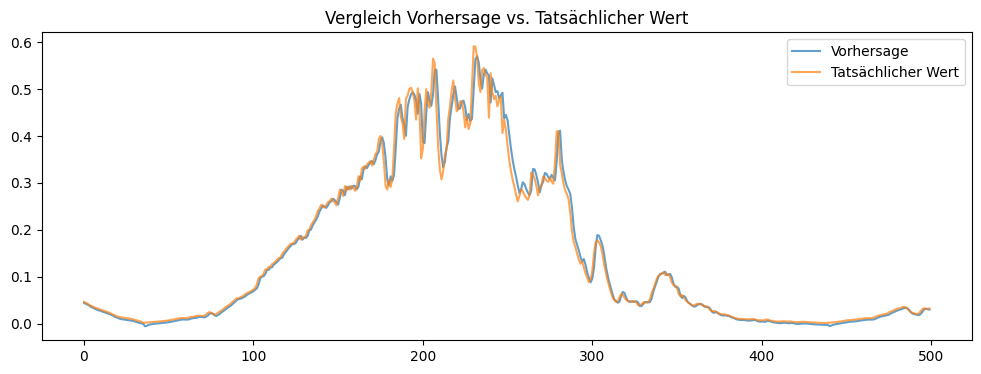

In [32]:
compare_model_output(model, X_val[:500], y_val[:500], plot_indices=None)

In [33]:

def plot_largest_deviation(y_pred, y_true, window=250):
    """
    Findet die größte Abweichung zwischen Vorhersage und Messwerten und plottet
    den Bereich von [i-window, i+window] um diesen Index herum.

    Parameter:
    -----------
    y_pred : np.array
        Array der Vorhersagewerte (z.B. Modelloutput).
    y_true : np.array
        Array der gemessenen True-Werte (Labels).
    window : int, optional (default=250)
        Anzahl an Werten vor und nach dem Index der größten Abweichung,
        die im Detailplot dargestellt werden sollen.

    Returns:
    -----------
    None (erstellt ein Plot).
    """

    # Sicherstellen, dass beide Arrays gleich lang sind
    if len(y_pred) != len(y_true):
        raise ValueError(f"Inkonsistente Längen: y_pred={len(y_pred)}, y_true={len(y_true)}")

    # Index der größten Abweichung bestimmen
    diff = np.abs(y_pred - y_true)
    max_idx = np.argmax(diff)

    print(y_pred[max_idx], y_val[max_idx])

    # Anzeigebereich für den Plot definieren (Begrenzung beachten)
    start_idx = max(0, max_idx - window)
    end_idx = min(len(y_pred), max_idx + window)

    # Plot erstellen
    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(start_idx, end_idx), y_true[start_idx:end_idx],
             label='Messwerte (y_val)', alpha=0.7)
    plt.plot(np.arange(start_idx, end_idx), y_pred[start_idx:end_idx],
             label='Vorhersage (y_pred)', alpha=0.7)
    # Hervorhebung des Punktes mit größter Abweichung
    plt.scatter(max_idx, y_true[max_idx], color='red', s=80, marker='x', label='Größte Abweichung')

    plt.title(f'Größte Abweichung bei Index={max_idx} (Abweichung={diff[max_idx]:.4f})')
    plt.xlabel('Index')
    plt.ylabel('Wert')
    plt.legend()
    plt.show()

0.47814327 0.07245769753842389


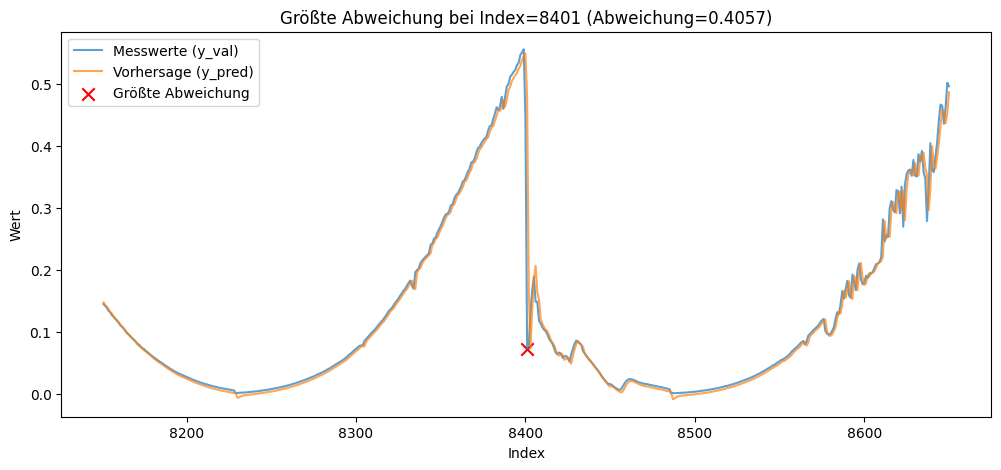

In [24]:
plot_largest_deviation(y_pred, y_val)